# TP1 Transfert de chaleur en milieu poreux en régime permanent

__4 séances__

L'objectif est de développer un module python qui résout le transfert de chaleur en milieu poreux en régime permanent.

Le code produit lors de ce TP de 4 séances servira ensuite de support à la réalisation des autres TPs.



## 1. Cas d'étude : l'interface nappe-rivière

L'interface nappe-rivière est ici représentée par une portion de zone hyporhéique mono-dimensionnelle de hauteur h.

Le couple d'équations régissant le transfert de chaleur correspond d'une part à la résolution du régime permanent hydraulique (loi de Darcy):

$ \boldsymbol{q} = -K \boldsymbol{\nabla} H $

couplée à l'équation de transfert de chaleur

$ \rho_w c_w \boldsymbol{q} \cdot \boldsymbol{\nabla} \theta - \lambda_m \Delta \theta = 0 $


avec $\boldsymbol{q}$, le débit spécifique [$m.s^{-1}$],  
$H$, la charge [$m$]  
$K$, la perméabilité [$m.s^{-1}$],  
$\theta$, la température [$K$],  
$\rho_w$, la densité de l'eau [$kg.m^{-3}$],  
$c_w$ la capacité calorifique spécifique de l'eau [$J.kg^{-1}.K^{-1}$],  
$\lambda_m$ [$W.m^{-1}.K^{-1}$] la conductivité thermique du milieu poreux équivalent, avec $\lambda_m = \left( n \sqrt{\lambda_w} + (1-n) \sqrt{\lambda_s} \right)^2$ où $n$ est la porosité du milieu, et les indices $w$ et $s$ dénotent respectivement l'eau et le solide pur.

$\boldsymbol{\nabla}$ est un opérateur différenciel et $\Delta$ le Laplacien. 
Les symboles en gras représentent des vecteurs. 

Afin de rendre le programme générique permettant éventuelelment de prendre en compte les effets de température sur les propriétés de l'eau, la loi de Darcy est écrite dans sa version intrinsèque :

$ \boldsymbol{q} = - \frac{k \rho_w g}{\mu_w} \boldsymbol{\nabla} H $

avec where $k$ la perméabilité intrinsèque de l'eau [$m^2$],  
$g$ la constante gravitaire [$m.s^{-2}$],  
$\mu_w$ la viscosité dynamique de l'eau [$kg.s^{-1}$].


Le système expérimental MOLONARI (MOnitoring LOcal des échanges NAppe-RIvière) permet de mesurer la différence de pression entre le haut et le bas de la colonne.


## 2. Discrétisation des équations en différences finies

On utilise par défaut un repère en z orienté vers le haut. Le zéro correspond au bas de la colonne (bot).

Le débit est constant tout au long de la colonne :

$ \boldsymbol{q} = -K_{eq} \frac{H_{top}-H_{bot}}{L} $,

L la longueur de la colonne de sol.


$ \rho_w c_w \boldsymbol{q} \cdot \boldsymbol{\nabla} \theta - \lambda_m \Delta \theta = 0 $

Soit $\kappa =  \frac{\lambda_m}{\rho_w c_w }$
alors $ \boldsymbol{q} \cdot \boldsymbol{\nabla} \theta - \kappa \Delta \theta = 0 $

__Discrétisation du premier terme__

$q_i \nabla \theta_i = q_i \frac{\theta_{i+1} - \theta{i-1}}{2 dz}$

dz longueur de la cellule,  

$q_i$ est la moyenne du débit aux faces: $q_i = \frac{q_{i+\frac{1}{2}}+ q_{i-\frac{1}{2}}}{2}$ 

Dans le cas permanent, ce débit est constant.

Si i est une cellule limite à température imposée alors i-1 devient i-1/2 et la formule :

$\nabla \theta_i = \frac{\theta_{i+1} - \theta{i-\frac{1}{2}}}{\frac{3}{2} dz}$

__Discrétisation du second terme__

$\Delta \theta_i = \nabla \nabla \theta_i$  
$\Delta \theta_i = \nabla \frac{\theta_{i+\frac{1}{2}} - \theta_{i-\frac{1}{2}}}{dz} $  
$\Delta \theta_i = \frac{\theta_{i+1} - 2 \theta_{i} + \theta{i-1}}{dz^{2}} $


Si i est une cellule limite à température imposée alors i-1 devient i-1/2  
$\Delta \theta_i = \nabla \frac{\theta_{i+\frac{1}{2}} - \theta_{i-\frac{1}{4}}}{\frac{3}{4}dz} $  
$\Delta \theta_i = \frac{4}{3 dz} [ \nabla \theta_{i+\frac{1}{2}} - \nabla \theta_{i-\frac{1}{4}} ] $   
$\Delta \theta_i = \frac{4}{3 dz} [ \frac{\theta_{i+1}-\theta_{i}}{dz} - 2 \frac{\theta_i - \theta_{i-\frac{1}{2}}}{dz} ] $  
$\Delta \theta_i = \frac{4}{3 dz^{2}} [ \theta_{i+1}-3 \theta_{i} + 2 \theta_{i-\frac{1}{2}} ] $  

__On obtient ainsi pour une cellule quelconque :__


$\theta_{i+1} - \theta_{i-1} - \frac{2 \kappa_i}{q_i dz} (\theta_{i+1} - 2 \theta_{i} + \theta_{i-1}) = 0$

$\boldsymbol{(q_i  - \frac{2 \kappa_i}{dz}) \theta_{i+1} + \frac{4 \kappa_i}{dz} \theta_{i}  - (q_i  +  \frac{2 \kappa_i}{dz}) \theta_{i-1} = 0}$

__Et pour une cellule limite à température imposée__  


$q_i (\frac{\theta_{i+1} - \theta{i-\frac{1}{2}}}{\frac{3}{2} dz}) - \kappa_i \frac{4}{3 dz^{2}} (\theta_{i+1}-3 \theta_{i} + 2 \theta_{i-\frac{1}{2}}) = 0$


$\theta_{i+1} - \theta_{i-\frac{1}{2}} - \frac{2 \kappa_i}{q_i  dz} ( \theta_{i+1}-3 \theta_{i} + 2 \theta_{i-\frac{1}{2}} ) = 0$


$\theta_{i+1} - \frac{2 \kappa_i}{q_i  dz} ( \theta_{i+1}-3 \theta_{i} ) = \theta_{i-\frac{1}{2}} + \frac{4 \kappa_i}{q_i  dz} + \theta_{i-\frac{1}{2}} $


$\boldsymbol{(q_i   - \frac{2 \kappa_i}{ dz} ) ( \theta_{i+1}) + \frac{6 \kappa_i}{ dz} \theta_{i}  = (q_i  + \frac{4 \kappa_i}{dz} )\theta_{i-\frac{1}{2}}} $



## 3. Formalisation du maillage, des variables d'état et des paramètres



### 3.1 Les classes considérées

La classe principale est la classe Column. Elle mobilise de nombreuses autres classes :

+ Point dans geometry.py 
+ Geometry dans geometry.py 
+ Face  dans geometry.py 
+ Cell  dans geometry.py 
+ PropPorousMedia  dans porousMedia.py 
+ PropHydro dans hydrogeology.py 
+ PropMedia dans heat.py 
+ Hydro dans hydrogeology.py 
+ Heat dans heat.py 
+ BoundaryConditionHyd  dans hydrogeology.py 
+ BoundaryConditionHeat dans heat.py 
+ LinSys dans linearAlgebra.py 

L'ensemble des fichiers *.py sont regroupés pour former un package dans le répertoire codepyheat. Ce package est initialisé par __init__.py qui permet de définir les paths relatifs, les CONST et les functions pour les imprimer en str. Le main.py peut ainsi être exécuté. Afin de rentre l'exécution du main encore plus générique, et surtout pour faire tourner les *.py de codepyheat indépendemment, il faut définir une variable globale d'environnement, en ajoutant le chemin vers le projet (ie le parent de codepyheat) à PYTHONPATH.

Enfin le fichier units.py assure les convertions d'unités en ayant recours au fichier de configuration __convOpTable.json qui ne doit pas être modifié par les utilisateurs.

Afin de pouvoir faire tourner le code dans le jupyter notebook, il est nécessaire de tout d'abord définir une metaclasse utile à la lecture des fichiers. Nous reviendrons donc ultérieurement sur le code relatif aux classes.

### 3.2 Instanciation des objets

L'instanciation des objet est basé sur la méthode __init__() de la classe correspondante. Par défaut, pour les classes qui nécessitent une définition par l'utilisateur, cette initialisation est basée sur l'utilisation d'un dictionary (dict). Afin de permettre une configuration aisée du code via des fichiers txt, il est possible de réaliser l'instanciation par le biais d'un fichier JSON. La définition de la méthode de classe d'instanciation par lecture de fichier est écrite dans factory.py : FactoryClass. Elle utilise des décorateurs et requière de ses héritiers de spécifier obligatoirement une méthode __init__ qui pourra être decorée par les méthodes méthodes de FactoryClass. Les classes dont les instances requiert une lecture de fichiers héritent de FactoryClass.  


### 3.3 La Classe Column

Elle contient l'ensemble des autres Classes et des methodes pour effectuer le calcul direct.
Auparavant définir PYTHONPATH here:


In [1]:
"""
    @author: Nicolas Flipo
    @date: 11.02.2021

    contains the main class Column that contains everything needed to
        run a simulation.
    Column is the most import class of pyHeat

    Classes Point, Geometry are important for the mesh definition,
        and maybe raster type plots
    Classes Cell and Face are functional objects that contains state
        variable Classes (Hydro and Heat)

    For this file to work autonomously, it is required to add the parent
        directory to the environment variable PYTHONPATH:
        export PYTHONPATH = $PYTHONPATH:<parent_dir>

"""

import sys
import numpy as np
import pathlib
import matplotlib.pyplot as plt

from codepyheat.factory import FactoryClass
from codepyheat import (X, Z, NDIM, N, S, complement, printDir, printDirCard,
                        caracItSteadyTemplate, caracParamTemplate)
from codepyheat.units import calcValMult
from codepyheat.heat import Heat, BoundaryConditionHeat, CODE_HEAT
from codepyheat.hydrogeol import Hydro, BoundaryConditionHyd, CODE_HYD
from codepyheat.porousMedia import PropPorousMedia, LAMBDAW
from codepyheat.linearAlgebra import LinSys
from codepyheat import JSONPATH


class Point:

    def __init__(self, x, z):
        self.x = x
        self.z = z

    def __str__(self) -> str:
        return "({},{}  {})".format(self.x, self.z, super.__str__(self))


class Geometry:
    area = 0

    def __init__(self, center, lenTuple):
        self.center = center
        self.lenTuple = lenTuple

    def getArea(self):
        if self.area == 0:
            self.area = self.lenTuple[X]*self.lenTuple[Z]
        return self.area
        # return self.lenTuple[X]*self.lenTuple[Z]


class Face:
    def __init__(self, id, length, dist):
        self.len = length
        self.dist = dist  # dist to next cell center
        # used for physical problem solving
        self.hydro = Hydro()
        self.heat = Heat()
        self.id = id


class Cell:
    def __init__(self, id, Center, SideLenTuple):
        self.id = id
        self.geom = Geometry(Center, SideLenTuple)
        self.face = [[], []]
        for i in range(NDIM):
            # self.face[i] = []
            for j in range(NDIM):
                idFace = "{}{}{}".format(id, printDir(i), printDirCard(i, j))
                self.face[i].append(
                    Face(idFace, SideLenTuple[complement(i)], SideLenTuple[i])
                )
        self.hydro = Hydro()
        self.heat = Heat()

    def getFace(self, dir, num):
        return self.face[dir][num]


class Column(FactoryClass):
    """
        instantiate with
            - Column(a_dict)
            - Column.fromJsonFile(full path and file name)
            - Column.fromJsonString(valid json string)

    """
    def __init__(self, a_dict):

        depth = calcValMult(a_dict['depth'], "depth")
        ncells = a_dict['ncells']

        self.depth = depth
        self.ncells = ncells
        self.sidelen = depth/ncells
        self.allocAndInitGeomCells()
        self.dh = CODE_HYD  # Hydraulic gradient driving the flow in the
        # Column. The elevation reference is the bottom of the column
        self.tempRiv = CODE_HEAT
        self.tempAq = CODE_HEAT
        self.ls = LinSys(self.ncells)

    def printProps(self):
        print('Caracteristics of the soil column:')
        print('\tdepth {} m'.format(self.depth))
        print('\tdepth', self.depth, 'm')
        print('\t', self.ncells, 'cells of side size', self.depth/self.ncells,
              'm')

    def allocAndInitGeomCells(self):
        sidelen = self.depth / self.ncells
        # print('side size', sidelen, 'm')
        xcoord = 0
        self.cell = []
        for i in range(self.ncells):
            zcoord = i * sidelen
            side_length = (sidelen, sidelen)
            self.cell.append(Cell(i, Point(xcoord + side_length[X]/2, zcoord +
                             side_length[Z]/2), side_length))

    def initColumnHydrostatique(self, H):
        for i in range(self.ncells):
            cell = self.cell[i]
            cell.hydro.h = H
            for k in range(NDIM):
                cell.face[Z][k].hydro.h = H

    def setBcHyd(self, name):
        bchyd = BoundaryConditionHyd.fromJsonFile(name)
        self.dh = bchyd.dh
        cell = self.cell[0]
        cell.hydro.setDirichletCell(Z, S)
        face = cell.getFace(Z, S)
        face.hydro.setDirichletFace(0)
        cell = self.cell[self.ncells - 1]
        cell.hydro.setDirichletCell(Z, N)
        face = cell.getFace(Z, N)
        face.hydro.setDirichletFace(self.dh)

    def setBcT(self, name):
        bcT = BoundaryConditionHeat.fromJsonFile(name)
        self.tempAq = bcT.tempAq
        self.tempRiv = bcT.tempRiv
        cell = self.cell[0]
        cell.heat.setDirichletCell(Z, S)
        face = cell.getFace(Z, S)
        face.heat.setDirichletFace(self.tempAq)
        cell = self.cell[self.ncells - 1]
        cell.heat.setDirichletCell(Z, N)
        face = cell.getFace(Z, N)
        face.heat.setDirichletFace(self.tempRiv)

    def setHomogeneousPorMed(self, name):
        propPorMed = PropPorousMedia.fromJsonFile(name)
        # propPorMed.printProps()
        self.physProp = propPorMed

    def solveDarcy(self):
        gradH = self.dh / self.depth
        for i in range(self.ncells):
            self.cell[i].hydro.calcU(gradH, self.physProp.getUpperK())

    def solveHydSteadyHeatSteady(self):
        self.solveDarcy()
        self.fillLinSysT()
        self.ls.solveSysLin()
        upperT = []
        # print(self.ls.x)
        for i in range(self.ncells):
            cell = self.cell[i]
            cell.heat.upperT = self.ls.x[i]
            upperT.append(cell.heat.upperT)
            cell.heat.specificHeatFlux = cell.heat.upperT * cell.hydro.upperU
        return upperT

    def fillLinSysT(self):
        self.solveDarcy()
        kappa = self.physProp.kappa
        kappa /= self.sidelen
        kappa *= 2
        ls = self.ls
        for i in range(self.ncells):
            l1 = l2 = l3 = r = CODE_HYD
            cell = self.cell[i]
            q = cell.hydro.upperU
            if cell.hydro.type == 'regular':
                l3 = q - kappa  # i+1
                l2 = 2 * kappa  # i
                l1 = - (q + kappa)  # i-1
                r = 0
            else:
                l2 = 3 * kappa  # i
                if cell.hydro.type == 'BcDirichlet, face -> ZS':
                    l3 = q - kappa  # i+1
                    r = (q + 2 * kappa) * cell.face[Z][S].heat.upperT
                elif cell.hydro.type == 'BcDirichlet, face -> ZN':
                    l1 = - (q + kappa)  # i-1
                    r = - (q - 2*kappa) * cell.face[Z][N].heat.upperT  # Check
                    # Calculate it explicitly
            ls.setLhsVal(i, i-1, l1)
            ls.setLhsVal(i, i, l2)
            ls.setLhsVal(i, i+1, l3)
            ls.setRhsVal(i, r)

    def setNameOutputT(self, it):
        pathlib.Path("./output").mkdir(parents=True, exist_ok=True)
        if it != "NONE":
            str = "./output/T{}.csv".format(it)
        else:
            str = "./output/T0.csv".format(it)
        return str

    def printFileT(self, file):
        original_stdout = sys.stdout
        sys.stdout = file
        for i in range(self.ncells):
            cell = self.cell[i]
            print(i*cell.geom.lenTuple[Z], ',', float(cell.heat.upperT))
        file.close()
        sys.stdout = original_stdout

    def printT(self):
        str = 'NONE'
        self.iterativePrintT(str)

    def iterativePrintT(self, it):
        with open(self.setNameOutputT(it), 'w') as file:
            self.printFileT(file)

    def plotT(self):
        upperT = []
        z = []
        for i in range(self.ncells):
            cell = self.cell[i]
            z.append(i*cell.geom.lenTuple[Z])
            upperT.append(cell.heat.upperT)
        plt.plot(upperT, z)
        plt.show()

    def iterativePlotT(self, it):
        data = np.genfromtxt(self.setNameOutputT(it), delimiter=',')
        plt.plot(data[:, 1], data[:, 0])
        plt.xlabel("Température in K")
        plt.ylabel("depth in m")
        plt.show()

    def selfIterativePlotT(self):
        physP = self.physProp
        it = caracItSteadyTemplate.format(
             physP.upperK(), physP.getLambda(), physP.getPorosity()
             )
        self.iterativePlotT(it)

    def setParamSteady(self, upperK, lambd, porosity, verbose):
        physP = self.physProp
        physP.setPermeability(upperK)
        if verbose:
            print(caracParamTemplate.format('\tpermeability:',
                  physP.getUpperK(), 'm s-1'))

        physP.setPorosity(porosity)     # Used in the lambda_eq formula
        if verbose:
            print(caracParamTemplate.format(
                '\tporosity', physP.getPorosity(), '--')
            )

        physP.setLambda(lambd)
        if verbose:
            print(caracParamTemplate.format(
                '\tequivalent thermal conductivity:',
                physP.getLambdaEq(LAMBDAW, physP.getPorosity()),
                'W m-1 K-1')
            )

        physP.setEffectiveParams()  # calculates kappa

    def runForwardModelSteadyState(
            self,
            upperK,
            lambd,
            porosity,
            verbose=True,
            export=True,
            draw=True):

        """
            parameters of the sensitivity analysis and bayesian inversion:
            - permeability, thermal conductivity, porosity
        """
        self.setParamSteady(upperK, lambd, porosity, verbose)
        upperT = self.solveHydSteadyHeatSteady()     # runs the fwd model
        if export:
            physP = self.physProp
            it = caracItSteadyTemplate.format(
                physP.getUpperK(), physP.getLambda(), physP.getPorosity()
            )
            self.iterativePrintT(it)
            if draw:
                # impossible to draw without export.
                # Draw is therefore conditional to the export
                self.iterativePlotT(it)
        return upperT


if __name__ == '__main__':
    col = Column.fromJsonFile(JSONPATH + 'configColumn.json')
    col.printProps()


Caracteristics of the soil column:
	depth 1.0 m
	depth 1.0 m
	 100 cells of side size 0.01 m


Les fichiers de configuration json sont tous contenus dans le répertoire json de codepyheat

Le premier configColumn.json décrit la géométrie de la colonne :  
{  
    "depth": {  
            "val": "100",  
            "unit": "cm"  
        },  
    "ncells": 100    
}  

Le second paramColumn.json décrit les noms des fichiers décrivant les propriétés de la colonne :  
{  
    "name": "Soil Column",  
    "hydroFile": "paramHyd.json",  
    "sedFile": "paramSed.json"    
}  

paramHyd.json décrit les propriétés hydrodynamiques :  
{  
    "hydro": {   
        "permeability" : {  
            "val": "1e-5",  
            "unit": "m/s"  
        },  
        "porosity" : {  
            "val" : "0.15"  
        }  
    }  
}  

paramSed.json, les propriétés thermiques des grains du milieu poreux:  
{    
    "sediment": {  
        "specificHeatCapacity" : {  
            "val": "957",  
            "unit" : "m2 s-2 K-1"  
        },  
        "lambda" : {  
            "val": "2",   
            "unit": "W m-1 K-1"  
        },  
        "rho" : {  
            "val" : "2600",  
            "unit" : "kg/m3"  
        }  
    }  
}  

Les conditions limites hydrauliques et thermiques sont contenues respectivement dans :
+ configBcHydro :  
{  
    "dH" : {  
        "val": 5,  
        "unit": "cm"  
    }  
}   

+ et configBcTemp :  
{  
    "Triv" : {  
        "val" : 29,  
        "unit" : "°C"  
    },  
    "Taq" : {  
        "val" : 12,  
        "unit" : "°C"  
    }  
}  




## 4. Sorties du code

Les méthodes d'impression et de visualisation sont définies dans geometry.py. Il est possible de les lancer via un script python basé sur le package codepyheat.


Caracteristics of the soil column:
	depth 1.0 m
	depth 1.0 m
	 100 cells of side size 0.01 m
Hydraulic Properties of porous media Unknown
	permeability or hydraulic conductivity: 1.000e-05 m s-1
	porosity: 1.500e-01 --
Thermal Properties of the phase (pure solid) Soil Column
	thermal conductivity:: 2.000e+00 W m-1 K-1
	specific heat capacity:: 9.570e+02 m2 s-2 K-1
	density:: 2.600e+03 kg m-3
equivalent parameters of  Soil Column :
	equivalent thermal conductivity: : 1.737e+00 W m-1 K-1
effective parameters of {}:
 Soil Column
	effective thermal conductivity: 4.151e-07 TO SPECIFY LATER


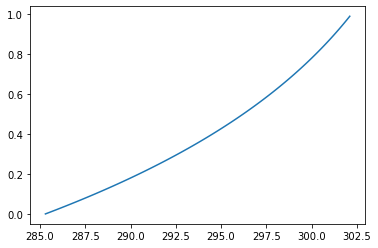

In [2]:
"""

    @author: Nicolas Flipo
    @date: 11.02.2021

    main file of pyHeat1D
    Everything is based on the Column class in geometry.py
        1.  initialisation from a JSON file
        2.  setting up the properties of the porous medium with JSON files
        3.  setting up the boundary conditions (hydraulique and thermal) with
            JSON files
        4.  solving the problem and printing and plotting the results
        5.  setting up other parameter values and solving again

"""
from codepyheat.geometry import Column
from codepyheat import JSONPATH

# step 1
rivBed = Column.fromJsonFile(JSONPATH + "configColumn.json")
rivBed.printProps()

# step 2
rivBed.setHomogeneousPorMed(JSONPATH + "paramColumn.json")
rivBed.physProp.printProps()

# step 3
rivBed.setBcHyd(JSONPATH + "configBcHydro.json")
rivBed.setBcT(JSONPATH + "configBcTemp.json")

# step 4 solving the problem and printing and plotting the results

rivBed.solveHydSteadyHeatSteady()
rivBed.printT()
rivBed.plotT()


## 5. Ecrire une fonctionalité du code permettant l'analyse de sensibilité

Il s'agit écrire d'écrire une méthode permettant de lancer un calcul direct en spécifiant les valeurs des trois paramètres intervenant dans le système d'équations : 
+ la perméabilité 
+ la conductivité thermique 
+ la porosité cinématique




	permeability:: 1.000e-03 m s-1
	porosity: 1.000e-01 --
	equivalent thermal conductivity:: 1.823e+00 W m-1 K-1


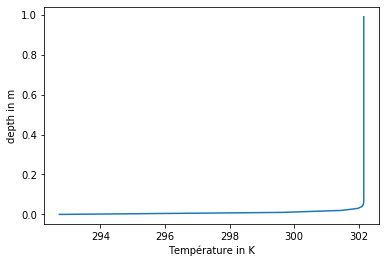

	permeability:: 1.000e-05 m s-1
	porosity: 1.000e-01 --
	equivalent thermal conductivity:: 1.823e+00 W m-1 K-1


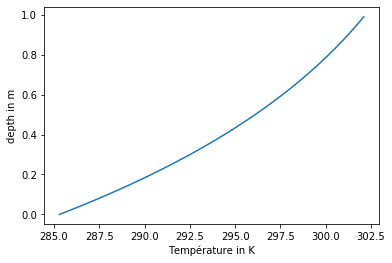

	permeability:: 1.000e-07 m s-1
	porosity: 1.000e-01 --
	equivalent thermal conductivity:: 1.823e+00 W m-1 K-1


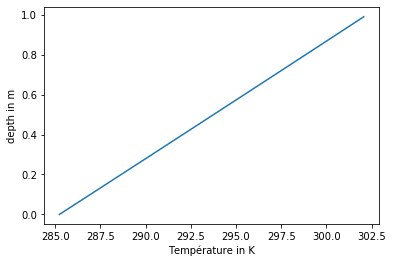

End of simulation pyHeat steady


In [3]:

# step 5 running forward model with other parameter values

rivBed.runForwardModelSteadyState(1e-3, 2, 0.1)

rivBed.runForwardModelSteadyState(1e-5, 2, 0.1)

rivBed.runForwardModelSteadyState(1e-7, 2, 0.1)
# rivBed.iterativePlotT(caracItSteadyTemplate.format(rivBed.physProp.upperK,rivBed.physProp.lambd,rivBed.physProp.n))

print('End of simulation pyHeat steady')